## Imports

In [1]:
!hostnamectl

 Static hostname: DGX
       Icon name: computer-server
         Chassis: server 🖳
      Machine ID: dedf5691225742ff95b33f842b0781cc
         Boot ID: cb04df0ff1774eeda112c63867eeefdd
Operating System: ]8;;https://www.ubuntu.com/Ubuntu 24.04.2 LTS]8;;              
          Kernel: Linux 6.8.0-53-generic
    Architecture: x86-64
 Hardware Vendor: NVIDIA
  Hardware Model: DGXA100 920-23687-2530-002
Firmware Version: 1.29
   Firmware Date: Tue 2024-08-06
    Firmware Age: 7month 3w 5d


In [2]:
%cd /home/ir739wb/ilyarekun/bc_project/centralized-learning/src/

/home/ir739wb/ilyarekun/bc_project/centralized-learning/src


In [3]:
import sys
import os
sys.path.append('../src')
from data_preprocessing import data_preprocessing_tumor_stratified
from model import BrainCNN, EarlyStopping
from collections import defaultdict

import numpy as np
import random
import torch
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from torch import nn
from torch import optim
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix


In [4]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False


In [5]:
train_loader, valid_loader, test_loader = data_preprocessing_tumor_stratified()
print("data was successfully loaded")

data was successfully loaded


In [6]:
print(f"Train dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(valid_loader.dataset)}")
print(f"Test dataset size: {len(test_loader.dataset)}")


Train dataset size: 4914
Validation dataset size: 1404
Test dataset size: 705


In [7]:

def count_images_per_class(loader):
    class_counts = defaultdict(int)

    for _, labels in loader:
        for label in labels:
            class_counts[label.item()] += 1  

    return class_counts

train_class_counts = count_images_per_class(train_loader)
valid_class_counts = count_images_per_class(valid_loader)
test_class_counts = count_images_per_class(test_loader)

print("Train loader class counts:")
for class_label, count in train_class_counts.items():
    print(f"Class {class_label}: {count} images")

print("\nValidation loader class counts:")
for class_label, count in valid_class_counts.items():
    print(f"Class {class_label}: {count} images")

print("\nTest loader class counts:")
for class_label, count in test_class_counts.items():
    print(f"Class {class_label}: {count} images")


Train loader class counts:
Class 2: 1400 images
Class 3: 1229 images
Class 1: 1151 images
Class 0: 1134 images

Validation loader class counts:
Class 0: 324 images
Class 1: 329 images
Class 2: 400 images
Class 3: 351 images

Test loader class counts:
Class 0: 163 images
Class 1: 165 images
Class 2: 200 images
Class 3: 177 images


In [8]:
model = BrainCNN()
#train_loader, valid_loader = ...  # Предполагается, что загрузчики данных уже есть
train_loss_metr, val_loss_metr, train_acc_metr, val_acc_metr, early_stopping = model.train_model(train_loader, valid_loader)

Using DataParallel for multi-GPU training


libibverbs: Warning: couldn't load driver 'libvmw_pvrdma-rdmav34.so': libvmw_pvrdma-rdmav34.so: cannot open shared object file: No such file or directory


Epoch 1: Train Loss: 1.1253, Val Loss: 1.5425
Epoch 1: Train acc: 0.4729, Val acc: 0.3462
Training completed in 22.42 seconds


Epoch 2: Train Loss: 0.8151, Val Loss: 1.3230
Epoch 2: Train acc: 0.6897, Val acc: 0.5214
Training completed in 42.65 seconds


Epoch 3: Train Loss: 0.6540, Val Loss: 1.2713
Epoch 3: Train acc: 0.7554, Val acc: 0.6068
Training completed in 63.40 seconds


Epoch 4: Train Loss: 0.5991, Val Loss: 0.9619
Epoch 4: Train acc: 0.7814, Val acc: 0.6695
Training completed in 84.09 seconds


Epoch 5: Train Loss: 0.5503, Val Loss: 0.8220
Epoch 5: Train acc: 0.7957, Val acc: 0.7187
Training completed in 104.98 seconds


Epoch 6: Train Loss: 0.5147, Val Loss: 0.9288
Epoch 6: Train acc: 0.8128, Val acc: 0.7094
Training completed in 125.26 seconds


Epoch 7: Train Loss: 0.4900, Val Loss: 0.7223
Epoch 7: Train acc: 0.8164, Val acc: 0.7486
Training completed in 146.15 seconds


Epoch 8: Train Loss: 0.4664, Val Loss: 0.7163
Epoch 8: Train acc: 0.8240, Val acc: 0.7493
Training co

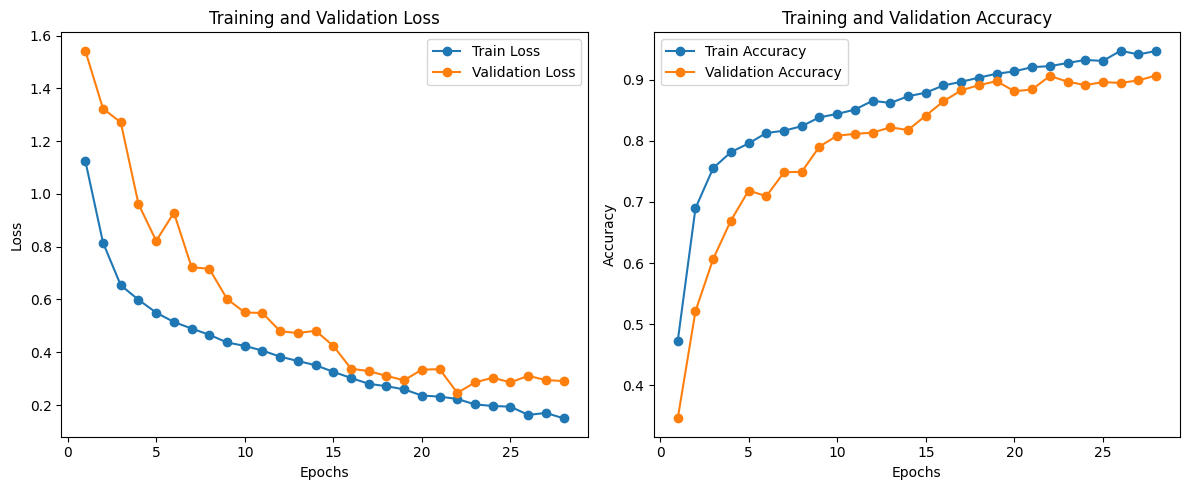

In [9]:
import matplotlib.pyplot as plt



epochs = range(1, len(train_loss_metr) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_metr, label="Train Loss", marker="o")
plt.plot(epochs, val_loss_metr, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_metr, label="Train Accuracy", marker="o")
plt.plot(epochs, val_acc_metr, label="Validation Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [10]:
save_path="./braincnn_prototype.weights"

In [11]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Создай модель
model = BrainCNN()  # Убедись, что создаёшь объект модели
model.to(device)

# Загрузите веса без изменения
state_dict = torch.load(save_path, map_location=device)

# Если модель была обучена с DataParallel, убери "module."
new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
model.load_state_dict(new_state_dict)

# Теперь можно обернуть в DataParallel, если используешь несколько GPU
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)


In [12]:


# Final evaluation on the test set
model.eval()
correct = 0
total = 0
test_targets = []
test_preds = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
        test_targets.extend(target.cpu().numpy())
        test_preds.extend(predicted.cpu().numpy())

test_accuracy =  correct / total

precision = precision_score(test_targets, test_preds, average='weighted')
recall = recall_score(test_targets, test_preds, average='weighted')
f1 = f1_score(test_targets, test_preds, average='weighted')

# Print the results
print('Metrics of the model on the test images:')
print(f'Accuracy: {test_accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

with open("training_metrics.pkl", "wb") as f:
    pickle.dump({
        "train_loss": train_loss_metr,
        "val_loss": val_loss_metr,
        "train_acc": train_acc_metr,
        "val_acc": val_acc_metr,
        "accuracy": test_accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }, f)

torch.save(model.state_dict(), "./braincnn_prototype.weights")

Metrics of the model on the test images:
Accuracy: 0.9078
Precision: 0.9073
Recall: 0.9078
F1 Score: 0.9072


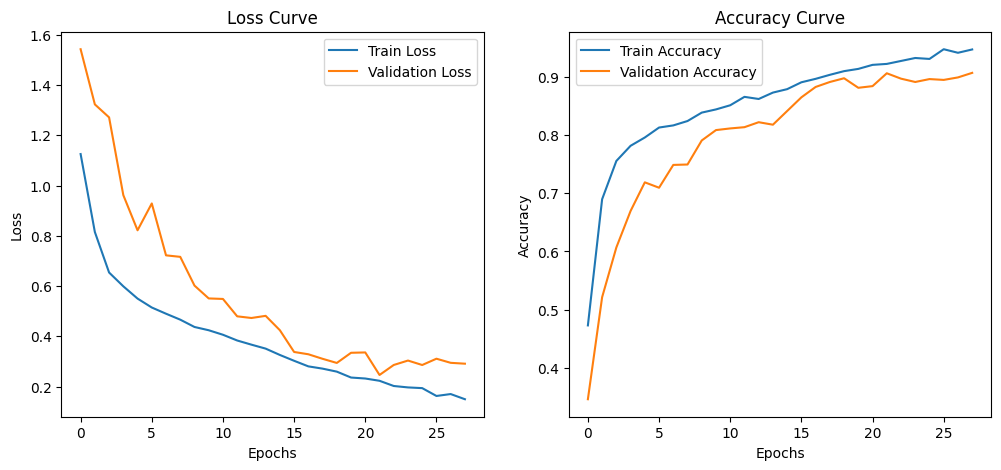

In [13]:
# Load metrics
with open("training_metrics.pkl", "rb") as f:
    metrics = pickle.load(f)

train_loss_metr = metrics["train_loss"]
val_loss_metr = metrics["val_loss"]
train_acc_metr = metrics["train_acc"]
val_acc_metr = metrics["val_acc"]

plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_loss_metr, label='Train Loss')
plt.plot(val_loss_metr, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(train_acc_metr, label='Train Accuracy')
plt.plot(val_acc_metr, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.savefig("training_plots.png", dpi=300, bbox_inches="tight")  # Сохранение в файл
plt.show()


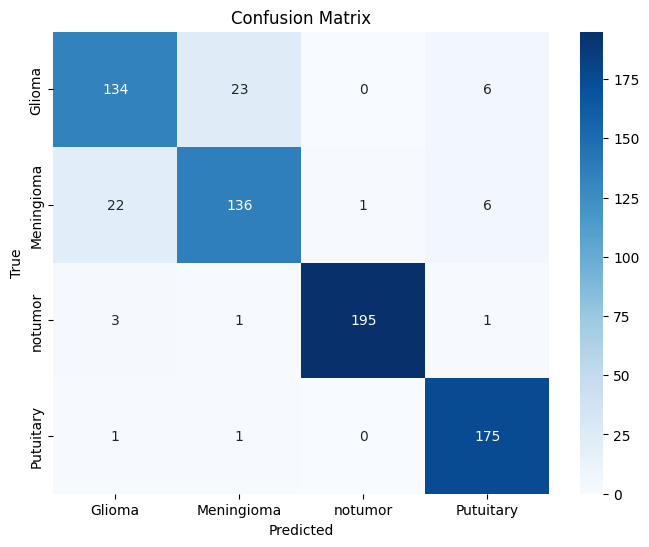

In [14]:


cm = confusion_matrix(test_targets, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Glioma', 'Meningioma', 'notumor', 'Putuitary'], 
            yticklabels=['Glioma', 'Meningioma', 'notumor', 'Putuitary'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

